In [1]:
import os
import re
import json
import shutil
import random
import traceback
import pickle as pkl
from datetime import datetime
from collections import Counter

import pytz
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import common

%matplotlib inline

/Users/sam/.pyenv/versions/3.6.5/envs/tomt-dataset/lib/python3.6/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/sam/.pyenv/versions/3.6.5/envs/tomt-dataset/lib/python3.6/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
plt.style.use('seaborn-colorblind')

In [3]:
folder = "./2018-2019/"

In [4]:
status_dict = common.load_meta("status_dict")
category_dict = common.load_meta("category_dict")
clean_rows = common.load_clean_rows(folder, status_dict, category_dict)
clean_df = pd.DataFrame([vars(r) for r in clean_rows])

100%|██████████| 211078/211078 [05:08<00:00, 684.65it/s]


In [20]:
moviedf = clean_df[clean_df.category == "movie/tv"]
moviedf.head(3)

,status,submission_id,category,original_category,date,hour,n_top_replies,n_total_replies,url,imdb_links,other_links
9,solved,cn9jlh,movie/tv,movie/tv,07-08-2019,18,5,13,https://www.reddit.com/r/tipofmytongue/comment...,[],[]
13,unknown,a5vjbs,movie/tv,movie/tv,13-12-2018,17,1,2,https://www.reddit.com/r/tipofmytongue/comment...,[https://www.imdb.com/title/tt5742374/?ref_=nv...,[]
26,solved,ah6njc,movie/tv,movie/tv,18-01-2019,4,3,8,https://www.reddit.com/r/tipofmytongue/comment...,[],[]


In [16]:
solved_moviedf = moviedf[moviedf.status == "solved"]
len(solved_moviedf)

20330

In [21]:
all_imdb_movies = Counter()
n_posts_with_imdb = 0
for m in solved_moviedf.imdb_links.values:
    all_imdb_movies += Counter(m)
    n_posts_with_imdb += 1 if len(m) > 0 else 0
    
all_imdb_movies.most_common(10)

[('https://www.imdb.com/title/tt1706593/', 8),
 ('https://www.imdb.com/title/tt1928340/', 6),
 ('https://www.imdb.com/title/tt1637688/', 5),
 ('https://www.imdb.com/title/tt0406375/', 5),
 ('https://www.imdb.com/title/tt3986820/', 5),
 ('https://www.imdb.com/title/tt0416236/', 5),
 ('https://www.imdb.com/title/tt0113538/', 4),
 ('https://www.imdb.com/title/tt0366780/', 4),
 ('https://www.imdb.com/title/tt5886440/', 4),
 ('https://www.imdb.com/title/tt0448011/', 4)]

In [22]:
len(all_imdb_movies), n_posts_with_imdb

(5467, 4596)

In [18]:
all_other_links = Counter()
for m in solved_moviedf.other_links.values:
    all_other_links += Counter(m)
all_other_links.most_common(10)

[('https://www.reddit.com/r/tipofmytongue/comments/6w64rm/mod_reply_solved_to_the_person_who_solves_your/#nocss',
  921),
 ('https://www.reddit.com/r/tipofmytongue/comments/6w64rm/mod_reply_solved_to_the_person_who_solves_your/?utm_source=share&utm_medium=web2x',
  903),
 ('https://old.reddit.com/r/tipofmytongue/comments/6w64rm#nocss', 100),
 ('https://www.reddit.com/r/tipofmytongue/comments/6w64rm/mod_reply_solved_to_the_person_who_solves_your/',
  53),
 ('https://www.reddit.com/r/tipofmytongue/wiki/faq', 52),
 ('https://www.reddit.com/r/tipofmytongue/wiki/rules', 51),
 ('https://reddit.com/message/compose?to=/r/tipofmytongue', 51),
 ('https://www.reddit.com/r/tipofmytongue/wiki/rules#wiki_3._title_format_.2B_body.',
  49),
 ('https://old.reddit.com/r/tipofmytongue/comments/clmizq/tomtseries_2000s_a_doctor_is_examing_a_scary/',
  35),
 ('https://tvtropes.org/pmwiki/pmwiki.php/WesternAnimation/MagiNation', 11)]

In [11]:
# make a subset of data
new_folder = "./2018-2019_solved_movies"
os.makedirs(new_folder, exist_ok=True)
for submission_id in solved_moviedf.submission_id.values:
    src = os.path.join(folder, submission_id + ".pkl")
    dst = os.path.join(new_folder, submission_id + ".pkl")
    
    shutil.copy(src, dst)

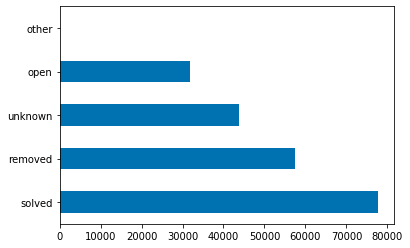

In [12]:
clean_df.status.value_counts().plot(kind="barh")

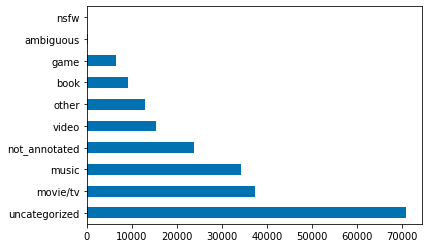

In [13]:
clean_df.category.value_counts().plot(kind="barh")

In [14]:
sorted_by_time = clean_df.assign(datetime = clean_df.date.apply(lambda _: datetime.strptime(_, "%d-%m-%Y")))
sorted_by_time['datetime'] = pd.to_datetime(sorted_by_time['datetime'])
sorted_by_time = sorted_by_time.assign(month = sorted_by_time.datetime.dt.month,
                                       day_of_week = sorted_by_time.datetime.dt.day_name())

In [15]:
def plot_bar_sorted(labels, values, sort_labels=False,
                    sort_values=False, sort_key=None,
                    reverse=False, barh=False, figsize=None):
    assert len(labels) == len(values)
    zipped = zip(labels, values)
    
    if sort_labels:
        sort_idx = 0
    elif sort_values:
        sort_idx = 1
    else:
        sort_idx = None
        
    if sort_key:
        zipped = sorted(zipped, key=sort_key, reverse=reverse)
    elif sort_idx:
        zipped = sorted(zipped, key=lambda _: _[sort_idx], reverse=reverse)
    
    if not figsize:
        figsize=(10, 10)
    plt.figure(figsize=figsize)
    
    bar_fn = plt.barh if barh else plt.bar
    
    
    zipped = (list(zipped))
    
    bar_fn([_[0] for _ in zipped],
            [_[1] for _ in zipped])
    
    

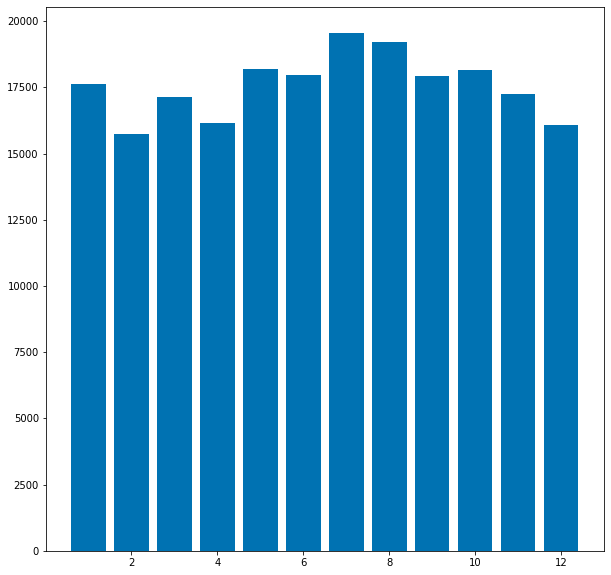

In [16]:
# plot month distribution
value_counts = sorted_by_time.month.value_counts()
index = value_counts.index.values
values = value_counts.values

plot_bar_sorted(
    index,
    values, sort_labels=True,    
)

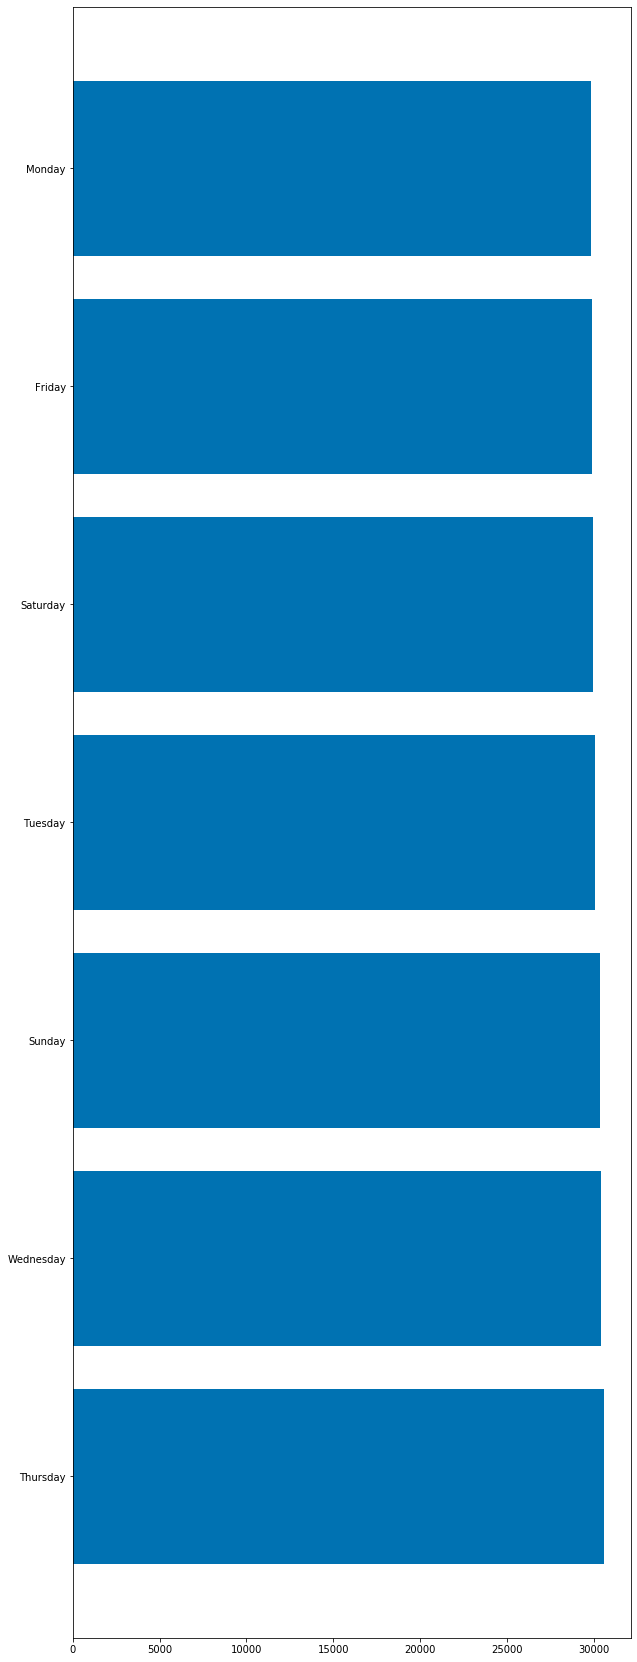

In [17]:
value_counts = sorted_by_time.day_of_week.value_counts()
index = value_counts.index.values
values = value_counts.values

plot_bar_sorted(
    index,
    values, sort_labels=True,
    barh=True,
    figsize=(10, 30)
)

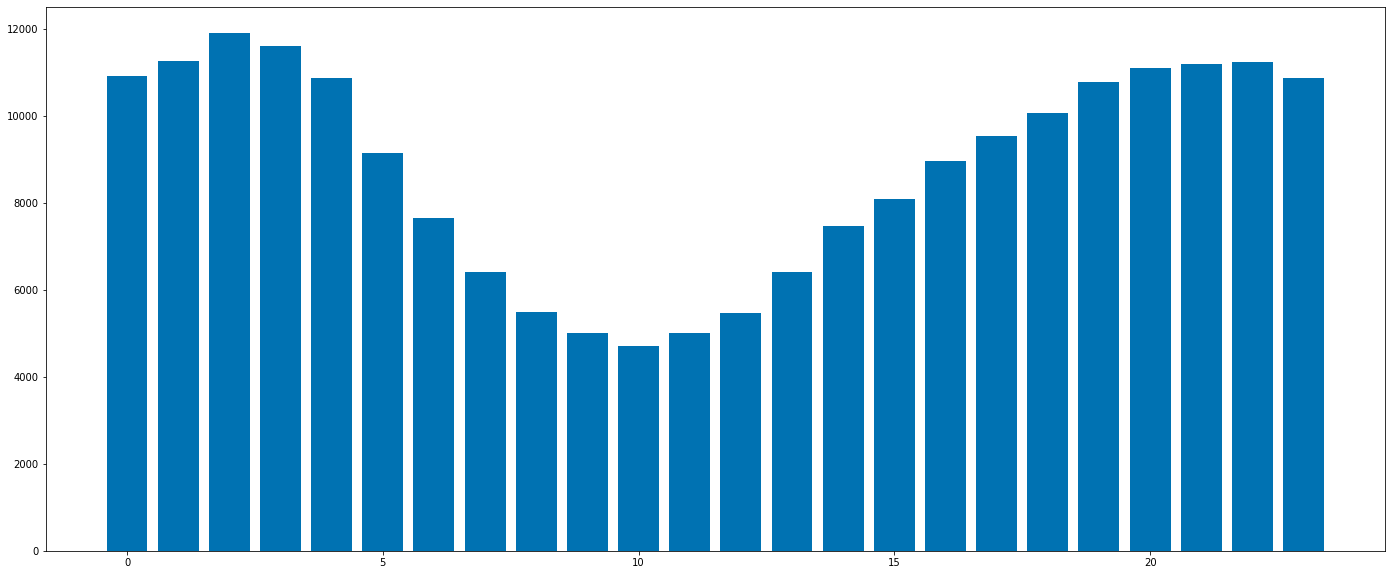

In [18]:
value_counts = sorted_by_time.hour.value_counts()
index = value_counts.index.values
values = value_counts.values

plot_bar_sorted(
    index,
    values, sort_labels=True, reverse=True,
    barh=False,
    figsize=(24, 10)
)

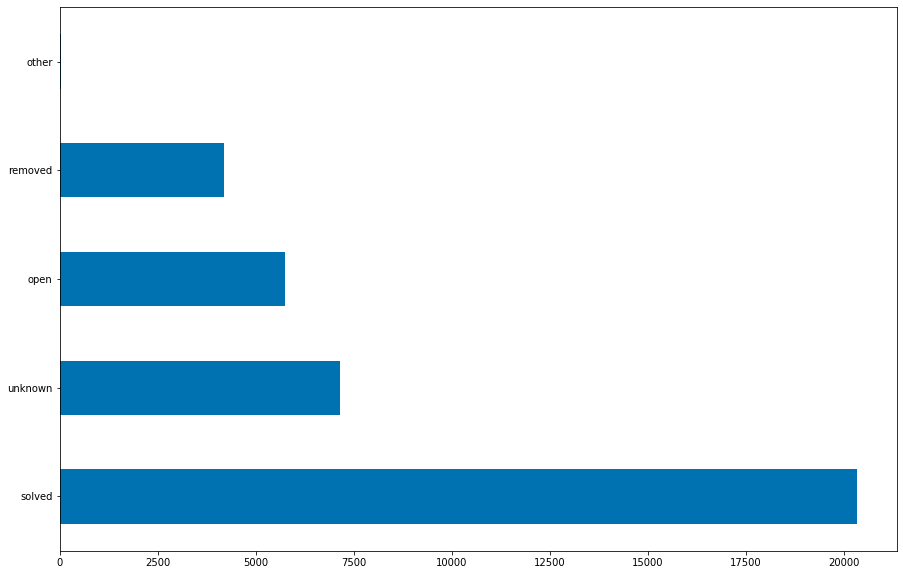

In [19]:
plt.figure(figsize=(15, 10))
moviedf.status.value_counts().plot(kind="barh")

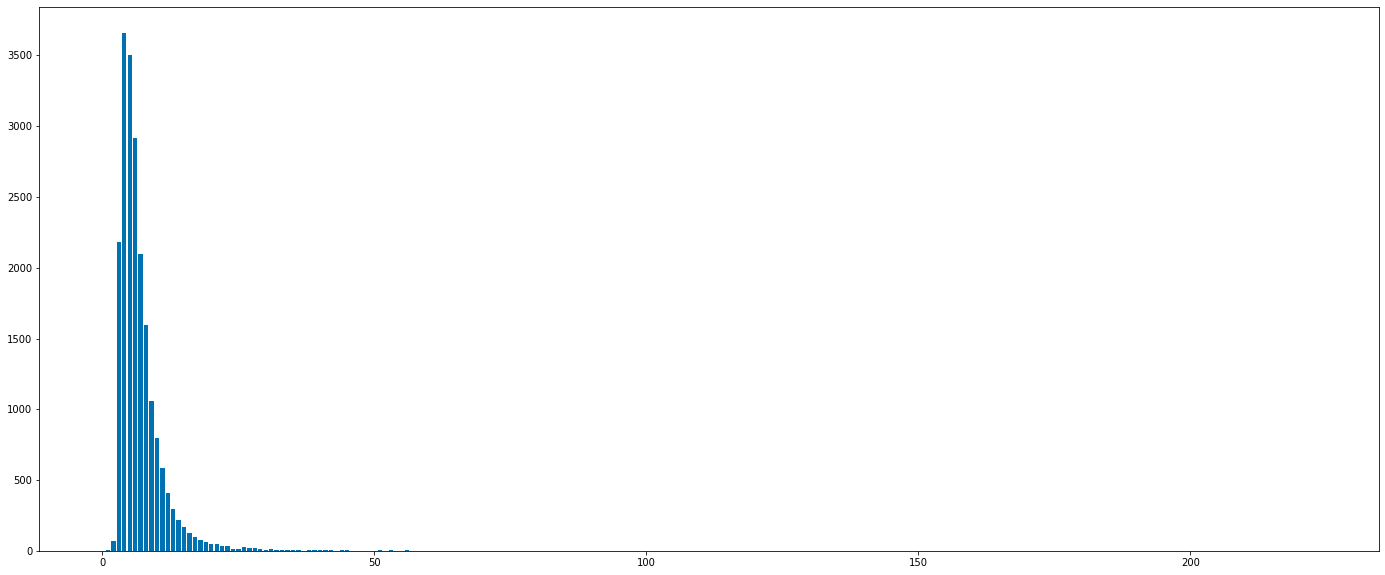

In [20]:
value_counts = solved_moviedf.n_total_replies.value_counts()
index = value_counts.index.values
values = value_counts.values

plot_bar_sorted(
    index,
    values, sort_labels=True, reverse=True,
    barh=False,
    figsize=(24, 10)
)
# solved_moviedf.n_total_replies.value_counts().plot(kind="barh")

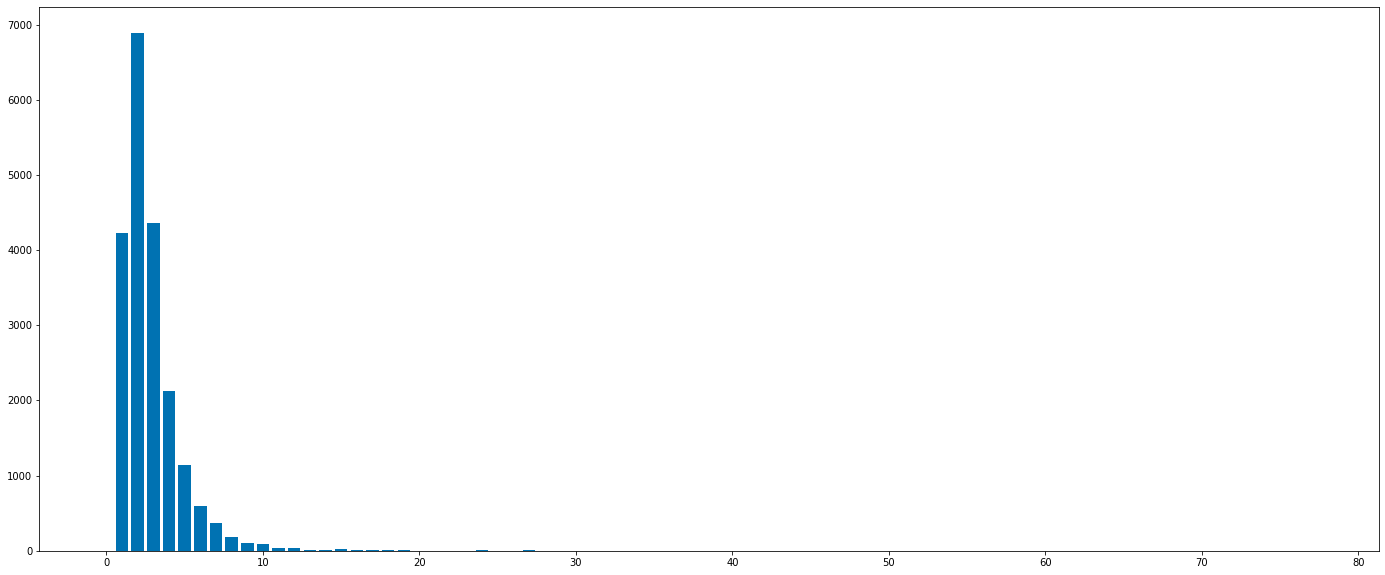

In [21]:
value_counts = solved_moviedf.n_top_replies.value_counts()
index = value_counts.index.values
values = value_counts.values

plot_bar_sorted(
    index,
    values, sort_labels=True, reverse=True,
    barh=False,
    figsize=(24, 10)
)

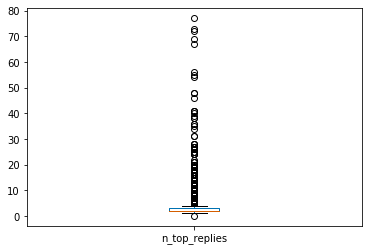

In [22]:
solved_moviedf.n_top_replies.plot(kind="box")

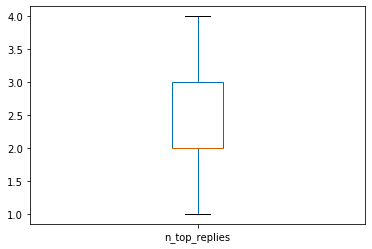

In [24]:
solved_moviedf.n_top_replies.plot(kind="box", showfliers=False)

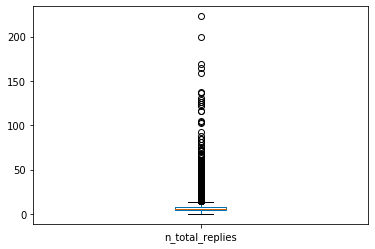

In [23]:
solved_moviedf.n_total_replies.plot(kind="box")

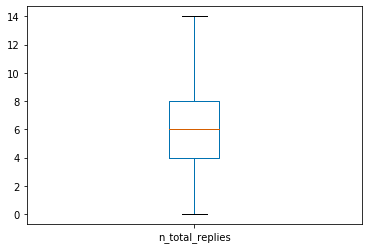

In [25]:
solved_moviedf.n_total_replies.plot(kind="box", showfliers=False)

In [26]:
total_replies = solved_moviedf.n_total_replies.values
np.mean(total_replies), np.median(total_replies), np.std(total_replies)

(7.015199212985736, 6.0, 6.310339049526555)

In [27]:
top_level_replies = solved_moviedf.n_top_replies.values
np.mean(top_level_replies), np.median(top_level_replies), np.std(top_level_replies)

(2.905853418593212, 2.0, 2.6310586133000036)